Load data:

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
(train_ds, test_ds), ds_info = tfds.load('mnist', split=['train', 'test'], as_supervised=True, with_info=True)

Preprocess data:

In [ ]:
def prepare_mnist_data(mnist):
  # change values from uint8 to float32
  mnist = mnist.map(lambda img, target: (tf.cast(img, tf.float32), target))
  # reshape image from 3D (28,28,1) to 1D (256,)
  mnist = mnist.map(lambda img, target: (tf.reshape(img, (-1,)), target))
  # normalize the vectors (from 0 - 255 to -1 - 1)
  mnist = mnist.map(lambda img, target: (((img/128.)-1.), target))
  # create one-hot targets for each handwritten numner (0-9)
  mnist = mnist.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
  # cache progress
  mnist = mnist.cache()
  # shuffle, batch, and prefetch data
  mnist = mnist.shuffle(1000)
  mnist = mnist.batch(32)
  mnist = mnist.prefetch(20)
  # return preprocessed dataset
  return mnist
  
# apply method to datasets
train_dataset = train_ds.apply(prepare_mnist_data)
test_dataset = test_ds.apply(prepare_mnist_data)

How many training/test images are there? **60,000/10,000**. What's the image shape? **28x28x1**. What range are pixel values in? **0-255**.


Create network:

In [ ]:
from tensorflow.keras.layers import Dense

class MyModel(tf.keras.Model):
    
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(256, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(256, activation=tf.nn.relu)
        self.out = tf.keras.layers.Dense(10, activation=tf.nn.softmax)

    @tf.function
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.out(x)
        return x

Create training loop:

In [ ]:
def train_step(model, input, target,loss_function, optimizer):
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

def test(model, test_data, loss_function):
  # binary attribute: right (1) or wrong (0) prediction?
  test_accuracy_aggregator = []
  # continuous attribute: how close is the output to the target?
  test_loss_aggregator = []

  for (input, target) in test_data:
    # prediction stays unseen to the network (does not update it's weights with respect to it)
    prediction = model(input)
    # same as in training: callable loss object
    sample_test_loss = loss_function(target, prediction)
    # is the highest value in our predicted outputs the same one as in our one-hot targets?
    sample_test_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    # average over batch size (32) -> get the mean: out of 32, how many were correct?
    sample_test_accuracy = np.mean(sample_test_accuracy)
    # append test losses
    test_loss_aggregator.append(sample_test_loss.numpy())
    # append the mean of the accuracy
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))    

  # Now we have a large list of accuracies and losses for all elements in the test data
  
  # Calculate mean of both loss and accuracy
  test_loss = tf.reduce_mean(test_loss_aggregator)
  test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

Start training:

In [ ]:
tf.keras.backend.clear_session()

#For showcasing we only use a subset of the training and test data (generally use all of the available data!)
train_dataset = train_dataset.take(1000)
test_dataset = test_dataset.take(100)

### Hyperparameters
num_epochs = 10
learning_rate = 0.1

# Initialize the model.
model = MyModel()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: SGD with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initialize lists for later visualization.
train_losses = []
test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')

    #training (and checking in with training)
    epoch_loss_agg = []
    for input,target in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)
    
    #track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))

    #testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: 0 starting with accuracy 0.1
Epoch: 1 starting with accuracy 0.05
Epoch: 2 starting with accuracy 0.06
Epoch: 3 starting with accuracy 0.06
Epoch: 4 starting with accuracy 0.09
Epoch: 5 starting with accuracy 0.08
Epoch: 6 starting with accuracy 0.09
Epoch: 7 starting with accuracy 0.08
Epoch: 8 starting with accuracy 0.05
Epoch: 9 starting with accuracy 0.13


Visualization:

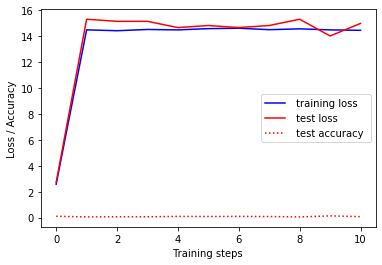

In [8]:
import matplotlib.pyplot as plt

def visualization (train_losses, test_losses,
test_accuracies):
  plt.figure()
  line1, = plt.plot(train_losses, "b-")
  line2, = plt.plot(test_losses, "r-")
  line3, = plt.plot(test_accuracies, "r:")
  plt.xlabel(" Training steps ")
  plt.ylabel (" Loss / Accuracy ")
  plt.legend((line1, line2, line3), (" training loss ", " test loss ", " test accuracy "))
  plt.show()

visualization(train_losses, test_losses, test_accuracies)

#Variations:

**Learning rate: 0.001 -> 0.1:** faster reduction of test loss and training loss, test loss went up a bit at the end, overall better result

**Learning rate = 0.1 X Batch Size: 32 -> 64:** not much has changed, loss doesn't go up, even slightly better result

**Learning rate = 0.1 X Batch Size = 1:** training loss and test loss do not get better, even higher, accuracy stays very low

**Learning rate = 0.1 X Batch Size = 64 X tf.keras.layers.Dense(units=256) -> 128:** very similar, except more volatile at the end, probably disadvantageous because of the inconsistency

**Learning rate = 0.1 X Batch Size = 64 X tf.keras.layers.Dense(units=256) -> 32:** very volatile, worse result, wouldn't recommend

**Learning rate = 0.1 X Batch Size = 32 X tf.keras.layers.Dense(units=256, activation.nn.relu) -> tf.math.sigmoid:** comparable result to ReLU



**Learning rate:** Up to a certain point, higher learning rates cause steeper declines in test and training loss. On the other side, there are more fluctations, as there is a higher risk of moving too far in the (negative) gradient direction. If the learning is too high (1 is already way too high), the network constantly overshoots in its gradient descents and does not considerably increase its accuracy during 10 epochs. The loss stays high and the accuracy low.

**Available data:** The network takes way longer to train if we use all the available data and not only take 1000 training examples and 100 test examples. Why is this affecting the speed so much? Because we have to iterate through all 60,000 training and 10,000 test samples

**See variation of plots here:** https://docs.google.com/document/d/1dlKWkrKuIfBjq-F9nI-VczJ88EwWX_4OhiSHYPZTIco/edit?usp=sharing